## DNN Baseline
 - 이 노트북은 DNN(Deep Neural Network)을 활용한 딥페이크 탐지 베이스라인 예시입니다.
 - 베이스라인은 Jupyter Notebook이며 프로젝트 진행 시 Python 스크립트 환경에서 작성하셔도 됩니다.

In [1]:
import os
import librosa
import matplotlib.pyplot as plt
import numpy as np

### 1. 데이터 전처리
 - DNN에 입력하기 위해 오디오 데이터를 특징 벡터로 변환합니다.  
 - 여기서는 MFCC, Delta, Delta-Delta 특징을 사용합니다.

In [2]:
# 훈련 데이터 metadata 경로 지정
train_metadata_path = '../2501ml_data/label/train_label.txt'

# 훈련 데이터 경로 지정
train_data_path = '../2501ml_data/train'

# 훈련 데이터의 음성 파일과 레이블을 저장할 리스트 초기화
train_x = []
train_y = []
with open(train_metadata_path, 'r') as f:
    # 각 줄을 읽어와서 음성 파일 경로와 레이블을 분리
    for line in f:
        # 각 줄은 화자, 파일 이름, 라벨로 구성되어 있음
        spk, file_name, _, _, label = line.strip().split(' ')
        
        # wav 경로
        wav_path = os.path.join(train_data_path, file_name)

        # MFCC, MFCC delta, MFCC delta-delta 추출
        y, sr = librosa.load(wav_path, sr=16000)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

        # MFCC, MFCC delta, MFCC delta-delta를 하나의 배열로 결합
        mfcc_combined = np.concatenate((mfcc, mfcc_delta, mfcc_delta2), axis=0)
        # 각 특징의 계수별 평균 계산
        mfcc_mean = np.mean(mfcc_combined, axis=1)

        # 훈련 데이터는 X에 저장
        train_x.append(mfcc_mean)

        # 라벨은 Y에 저장
        train_y.append(label)

In [3]:
print("훈련 데이터의 개수:", len(train_x))
print("훈련 데이터 X의 shape:", train_x[0].shape)

훈련 데이터의 개수: 4000
훈련 데이터 X의 shape: (60,)


In [4]:
# 테스트 데이터 metadata 경로 지정
test_metadata_path = '../2501ml_data/label/test_label.txt'

# 테스트 데이터 경로 지정
test_data_path = '../2501ml_data/test'

# 테스트 데이터의 음성 파일과 레이블을 저장할 리스트 초기화
test_file_names = []
test_x = []
test_y = []
with open(test_metadata_path, 'r') as f:
    # 각 줄을 읽어와서 음성 파일 경로와 레이블을 분리
    for line in f:
        # 각 줄은 화자, 파일 이름, 라벨로 구성되어 있음
        spk, file_name, _, _, label = line.strip().split(' ')
        
        # wav 경로
        wav_path = os.path.join(test_data_path, file_name)

        # MFCC, MFCC delta, MFCC delta-delta 추출
        y, sr = librosa.load(wav_path, sr=16000)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

        # MFCC, MFCC delta, MFCC delta-delta를 하나의 배열로 결합
        mfcc_combined = np.concatenate((mfcc, mfcc_delta, mfcc_delta2), axis=0)
        # 각 특징의 계수별 평균 계산
        mfcc_mean = np.mean(mfcc_combined, axis=1)

        # 테스트 데이터는 X에 저장
        test_x.append(mfcc_mean)

        # 라벨은 Y에 저장
        test_y.append(label)

        # 테스트 데이터 파일 이름 저장
        test_file_names.append(file_name)

In [5]:
print("테스트 데이터의 개수:", len(test_x))
print("테스트 데이터 X의 shape:", test_x[0].shape)

테스트 데이터의 개수: 2000
테스트 데이터 X의 shape: (60,)


### 2. DNN 훈련
 - DNN 객체를 생성합니다.
 - 훈련 데이터로 학습하고 테스트 데이터를 통해 정확도를 계산합니다.

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers

In [7]:
# 리스트를 numpy 배열로 변환
X_train = np.array(train_x)
X_test = np.array(test_x)

# 라벨 인코딩 (0: fake, 1: real)
le = LabelEncoder()
y_train = le.fit_transform(train_y)
y_test = le.transform(test_y)

# 원-핫 인코딩
y_train_oh = to_categorical(y_train)
y_test_oh = to_categorical(y_test)

In [8]:
# DNN 모델 정의
model = Sequential()

model.add(layers.Input(shape=train_x[0].shape))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

# 모델 컴파일
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 모델 요약 출력
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,050 (23.63 KB)

 Trainable params: 6,050 (23.63 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(
    X_train, y_train_oh,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test_oh),
    verbose=1
)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5993 - loss: 1.9798 - val_accuracy: 0.6545 - val_loss: 1.0257
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8665 - loss: 0.3287 - val_accuracy: 0.6510 - val_loss: 1.2770
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9254 - loss: 0.2163 - val_accuracy: 0.6855 - val_loss: 1.1185
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9473 - loss: 0.1506 - val_accuracy: 0.5925 - val_loss: 2.3581
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9590 - loss: 0.1272 - val_accuracy: 0.6585 - val_loss: 1.6625
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9596 - loss: 0.1111 - val_accuracy: 0.6530 - val_loss: 1.8158
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9733 - loss: 0.0865 - val_accuracy: 0.6540 - val_loss: 1.9984
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9770 - loss: 0.0687 - val_accuracy: 0.

In [10]:
# 훈련된 모델로 테스트 데이터 예측
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


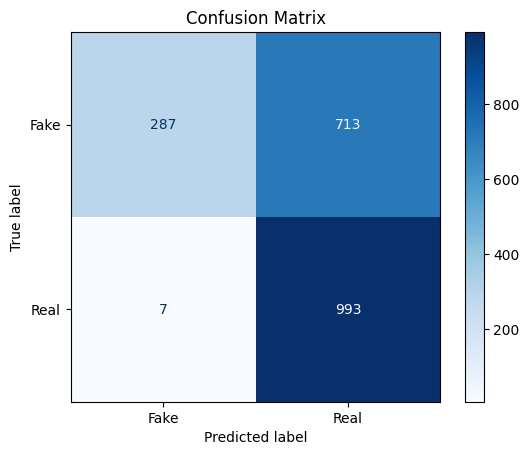

In [11]:
# 혼동 행렬(Confusion Matrix) 시각화
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

### 3. 예측 결과 파일 작성

In [12]:
with open('./team_test_result.txt', 'w') as f:
    for i in range(len(y_pred_classes)):
        label_str = le.inverse_transform([y_pred_classes[i]])[0]
        f.write(f"{test_file_names[i]} {label_str}\n")

In [13]:
!perl ../eval.pl ./team_test_result.txt ../2501ml_data/label/test_label.txt

============ Results Analysis ===========
Test: ./team_test_result.txt
True: ../2501ml_data/label/test_label.txt
Accuracy: 64.00%
Hit: 1280, Total: 2000
